In [67]:
import os 

In [68]:
%pwd

'C:\\Users\\RICH-FILES\\Desktop\\ml\\AI-powered-Bank-Product-Recommender-Chatbot'

In [69]:
os.chdir("../.")

In [70]:
%pwd

'C:\\Users\\RICH-FILES\\Desktop\\ml'

In [71]:
project_dir = "C:/Users/RICH-FILES/Desktop/ml/AI-powered-Bank-Product-Recommender-Chatbot"
os.chdir(project_dir)

In [72]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class DataTransformationConfig:
    """
    Data Transformation Configuration
    """
    root_dir: Path
    transformed_data_file: Path
    customer_path: Path
    product_path: Path
    train_data_file: Path
    test_data_file: Path

In [73]:
from BankProducts.constants import *
from BankProducts.utils.common import read_yaml, create_directories

In [74]:
class ConfigurationManager:
    def __init__(
        self,
        config_filepath = CONFIG_FILE_PATH,    
        params_filepath = PARAMS_FILE_PATH,
        #schema_filepath = SCHEMA_FILE_PATH,
        ):
       
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        #self.schema = read_yaml(schema_filepath)        
    
        create_directories([self.config.artifacts_root])
        
    def get_data_transformation_config(self)-> DataTransformationConfig:
        """
        Returns Data Transformation Configuration
        """
        config = self.config.data_transformation
        
        create_directories([self.config.artifacts_root])
        
        data_transformation_config = DataTransformationConfig(
            root_dir=Path(config.root_dir),
            transformed_data_file= Path(config.transformed_data_file),
            product_path= Path(config.product_path),
            customer_path= Path(config.customer_path),
            train_data_file= Path(config.train_data_file),
            test_data_file= Path(config.test_data_file)
            )
        
        
        return data_transformation_config
    

In [75]:



import os  
from BankProducts import logger
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
     


In [76]:
class DataTransformation:
    def __init__(self, config: DataTransformationConfig):
        self.config = config
        #self.data = None
        #self.transformed_data = None
        
    def join_datasets(self):
        """
        Join customer and product datasets"""    
        try:
            customer_data = pd.read_csv(self.config.customer_path)
            product_data = pd.read_csv(self.config.product_path)

            # Ensure the directory for saving exists
            output_dir = os.path.dirname(self.config.transformed_data_file)
            os.makedirs(output_dir, exist_ok=True)

            # Join operation
            joined_data = pd.merge(customer_data, product_data, how="left",
                                left_on="existing_products", right_on="product_name")
            
            #drop unnecessary columns
            joined_data = joined_data.drop(columns=['existing_products'])
            
            #check the dataset head
            print(joined_data.head())
            
            
            # Save the joined data
            joined_data.to_csv(self.config.transformed_data_file, index=False)

        except Exception as e:
                print(f"Error joining datasets: {e}")
                
    def transform_data(self):
        """
        Transform the data as per the requirements
        """
        try:
            # Load the data
            self.data = pd.read_csv(self.config.transformed_data_file)
            # Perform transformations
            print(self.data.head())
            
            print(":"*100)
            
            self.data.info()
            print(":"*100)
            
            self.data.describe()
            print(":"*100)
            print(self.data.columns)
            print(":"*100)
            
            #plot "product_name" histogram based of gender using seaborn
            plt.figure(figsize=(10,6))
            sns.histplot(x='product_name', data=self.data, hue='gender', multiple="dodge", palette="Blues")
            plt.xlabel("product name")
            plt.ylabel("count")
            plt.title("Product Name Histogram by Gender")
            plt.show()
            plt.savefig("product name histogram by gender.png")
           
            
            #plot "age" histogram
            plt.figure(figsize=(10,6))
            plt.hist(self.data["age"], bins=10, edgecolor='black', color= "orange", alpha=0.7)
            plt.title("Age Frequency Distribution")
            plt.xlabel("Age")
            plt.ylabel("Frequency")
            plt.savefig("age_histogram.png")
            
        
           
            #plot "product_name" vs "age" bar plot
            plt.figure(figsize=(10,6))
            plt.bar(self.data["product_name"], self.data["age"], color="green")
            plt.title("Product Name vs Age Bar Plot")
            plt.xlabel("Product Name")
            plt.ylabel("Age")
            plt.savefig("product_name_vs_age_bar_plot.png")
            
            
            
            #feature engineering
            # Convert categorical variables to numerical using OneHotEncoder
            categorical_features = self.data.select_dtypes(include=['object']).columns.tolist()
            numerical_features = self.data.select_dtypes(exclude=['object']).columns.tolist()
            categorical_features.remove('product_name')  # Exclude target variable
        
            # OneHotEncoder 
           
            # Create a ColumnTransformer to handle categorical and numerical features
            preprocessor = ColumnTransformer(
                transformers=[
                    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output= False), categorical_features),
                    ('num', SimpleImputer(strategy='mean'), numerical_features)
                ],
                remainder='passthrough'  # Keep other columns as they are
            )
            # Create a pipeline with the preprocessor
            pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('scaler', StandardScaler())  # Optional: Add a scaler if needed
            ])
            # Fit and transform the data
            transformed_data = pipeline.fit_transform(self.data)
            # Convert the transformed data back to a DataFrame
            transformed_df = pd.DataFrame(transformed_data, columns=pipeline.get_feature_names_out())
            # Save the transformed data to a CSV file
            transformed_df.to_csv(self.config.transformed_data_file, index=False)
            logger.info("Datasets joined and transformed successfully")
            print("Datasets joined and transformed successfully")
            # Ensure the directory for saving exists
            os.makedirs(os.path.dirname(self.config.transformed_data_file), exist_ok=True)
            # Check the shape of the joined data
            print(f"Joined data shape: {transformed_data.shape}")
            # Check the first few rows of the joined data
            print("First few rows of the joined data:")
            print(transformed_data.head())
            # Check the columns of the joined data      
            print("Columns of the joined data:")
            print(transformed_data.columns)
            
            #feature selection
            # If it's a categorical variable like a string, correlation won't work correctly
            correlation_matrix = transformed_data.corr()
            target_variable = 'product_name'

            # Confirm product_name is in the correlation matrix
            if target_variable in correlation_matrix.columns:
                top_features = correlation_matrix[target_variable].abs().nlargest(10).index.tolist()
                
                # Plot correlation heatmap of top features
                sns.heatmap(transformed_data[top_features].corr(), annot=True, cmap='coolwarm')
                plt.title("Top 10 Features Correlated with 'product_name'")
                plt.show()
                plt.savefig("correlation_matrix.png")
                
            else:
                print(f"'{target_variable}' is not numeric or not in the correlation matrix.")
                
            # Create a new DataFrame with the selected features
            selected_features_df = transformed_data[top_features]
            # Save the selected features to a CSV file
            selected_features_df.to_csv(self.config.transformed_data_file, index=False)
            # Check the shape of the selected features
            print(f"Selected features shape: {selected_features_df.shape}")
            
            
            
            
            # Example transformation: splitting data into train and test sets
            train_data, test_data = train_test_split(self.data, test_size=0.2)
            self.transformed_data = {
                "train": train_data,
                "test": test_data
            }
            
        
        
        
            #save train_data and test_data to csv files
            train_data.to_csv(self.config.train_data_file, index=False)
            test_data.to_csv(self.config.test_data_file, index=False)
            
            logger.info("Data transformed successfully")
        except Exception as e:
            logger.error(f"Error transforming data: {e}")
            raise

            
        
    
        

[2025-05-24 13:19:35,286: INFO: common: yaml file: config\config.yaml loaded successfully]
[2025-05-24 13:19:35,289: INFO: common: yaml file: params.yaml loaded successfully]
[2025-05-24 13:19:35,291: INFO: common: created directory at: artifacts]
[2025-05-24 13:19:35,292: INFO: common: created directory at: artifacts]


                            customer_id              name  age  gender  \
0  46a7de50-f684-4659-89d6-f716cd5452bb   Shannon Schultz   34  Female   
1  dfaedadd-1aaa-4174-bb24-a1c59cae6923      Paul Salinas   51  Female   
2  9352ea62-afe5-4bd2-8e84-6153f3810095       Jenna Sharp   29  Female   
3  2038abc4-6d7b-428e-b701-05f9597bc8b7      Julie Nguyen   58  Female   
4  826d887f-284e-4d42-a3a8-0296c1339049  Stephanie Patton   33  Female   

                  occupation  annual_income marital_status  credit_score  \
0            Event organiser      188422.83         Single           355   
1  Estate manager/land agent      112820.75         Single           652   
2               Tour manager       60639.02         Single           504   
3      Scientist, biomedical      144937.48         Single           723   
4               Risk manager      110584.84        Married           475   

  financial_goals   product_name  \
0      Retirement            NaN   
1         Savings         

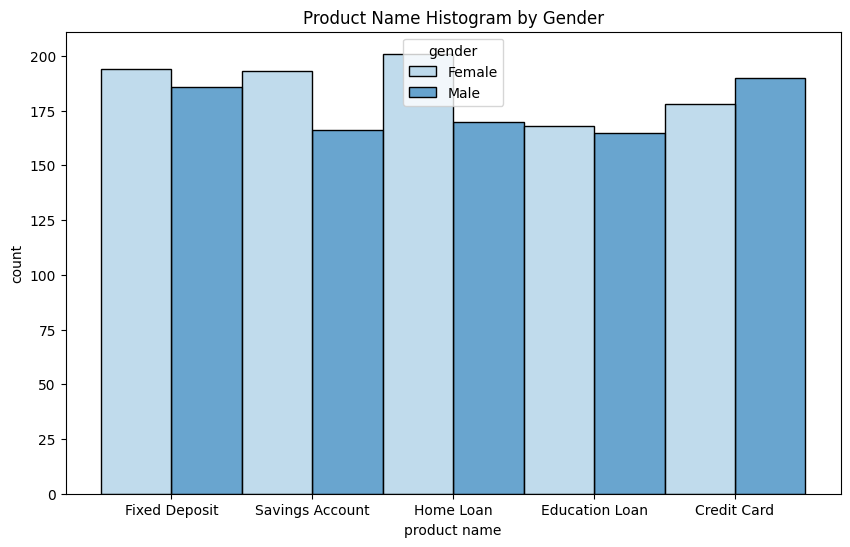

[2025-05-24 13:19:35,963: ERROR: 524015610: Error transforming data: 'value' must be an instance of str or bytes, not a float]
[2025-05-24 13:19:35,964: ERROR: 418413119: Error in data transformation: 'value' must be an instance of str or bytes, not a float]


TypeError: 'value' must be an instance of str or bytes, not a float

<Figure size 640x480 with 0 Axes>

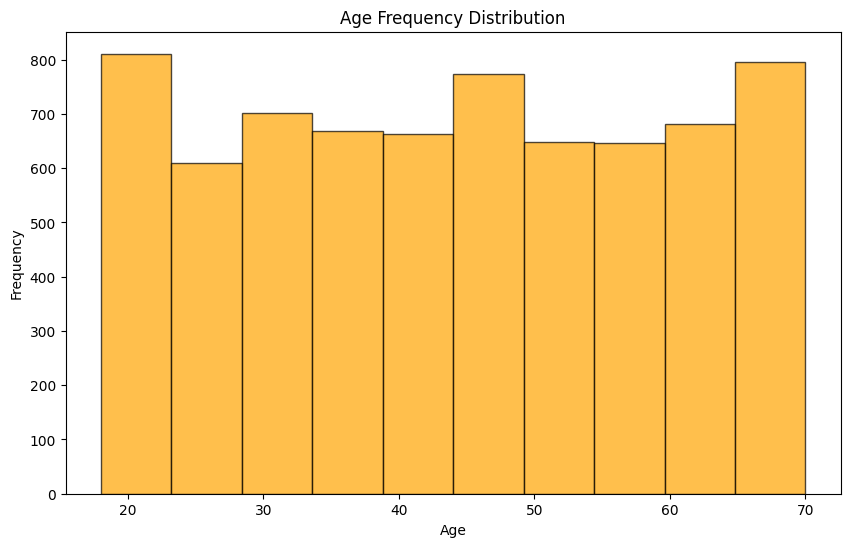

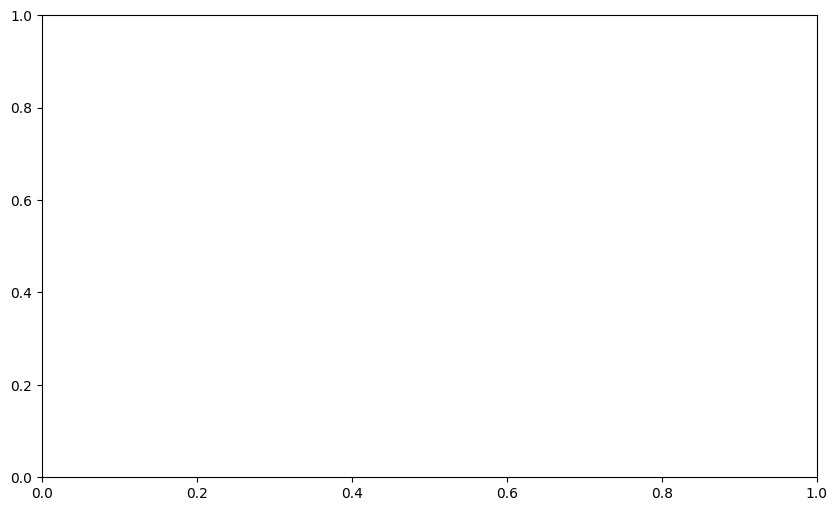

In [77]:
try:
    config = ConfigurationManager()
    data_transformation_config = config.get_data_transformation_config()
    
    data_transformation = DataTransformation(config=data_transformation_config)
    data_transformation.join_datasets()
    data_transformation.transform_data()
except Exception as e:
    logger.error(f"Error in data transformation: {e}")
    raise  e